In [2]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.utils import resample

# TEST TO LOAD DATASET
df = pd.read_csv('heart.csv')
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


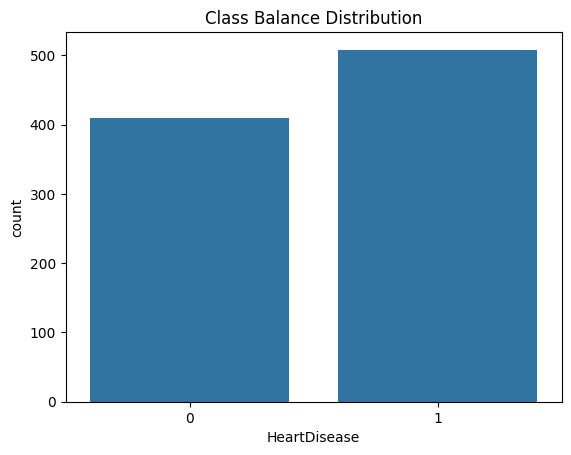

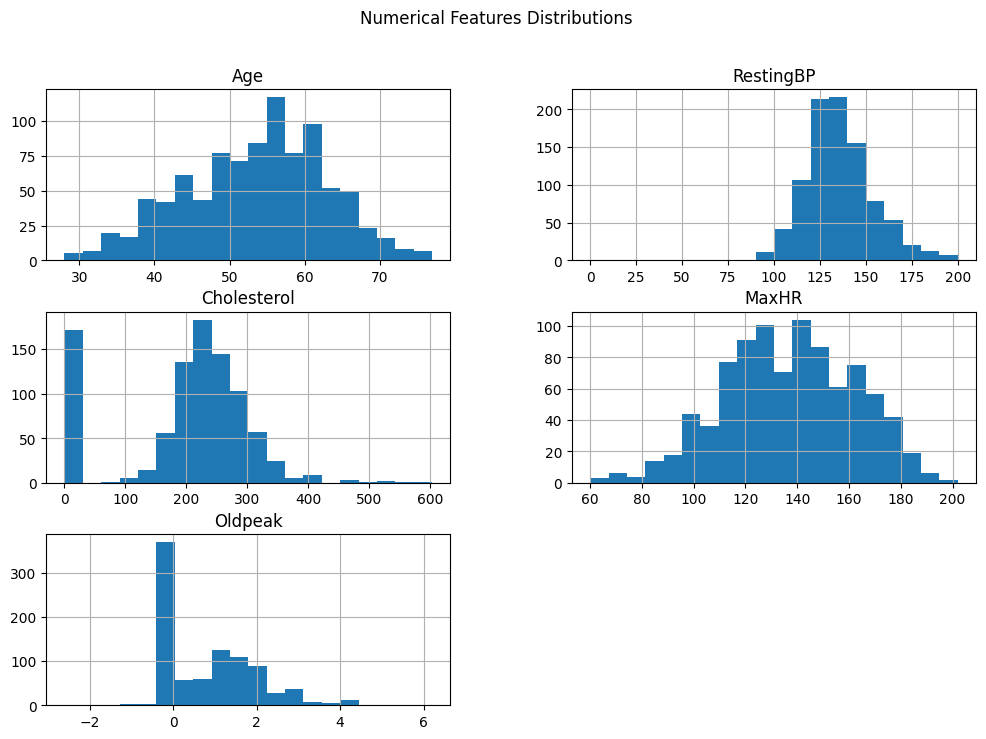

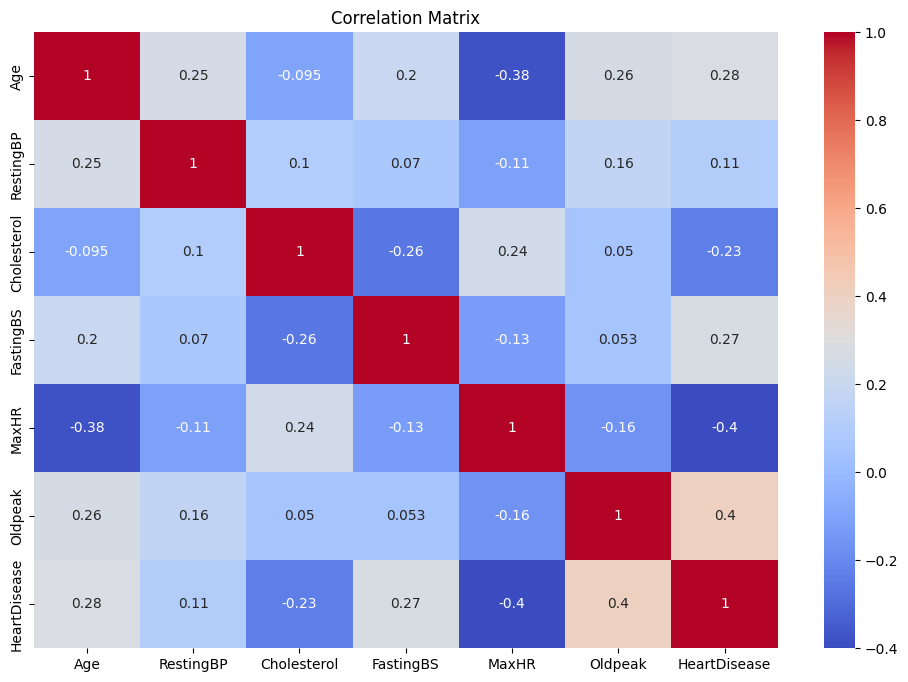

Missing values:
Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64
Class distribution before splitting: HeartDisease
1    508
0    410
Name: count, dtype: int64
Train class distribution: HeartDisease
1    406
0    328
Name: count, dtype: int64


C:\Users\Kenneth Samaniego\AppData\Local\Temp\ipykernel_41452\1945885341.py:31: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[i].fillna(df[i].median(), inplace=True)
C:\Users\Kenneth Samaniego\AppData\Local\Temp\ipykernel_41452\1945885341.py:31: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves

In [3]:
# PART 1: Preprocessing

# EDA =================================
df.info() #general info
df.describe(include='all') # stats

#checking for class balance
sns.countplot(x='HeartDisease', data=df)
plt.title('Class Balance Distribution')
plt.show()

# Distributions for numerical features (age, restingbp, cholestrerol, etc.)
features = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
df[features].hist(figsize=(12,8), bins=20)
plt.suptitle('Numerical Features Distributions')
plt.show()

#correlations
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Missing vals & outliers =================================
print('Missing values:')
print(df.isnull().sum()) # check for missing values (aka NULL)

#handle missing/zeroes in Cholesterol & Resting BP values since those physically can't be 0
for i in ['Cholesterol', 'RestingBP']:
    df[i] = df[i].replace(0, np.nan) #replaces 0's w/ NaN's
    df[i].fillna(df[i].median(), inplace=True)

#handle outliers (w/ IQR)
for i in features:
    Q1 = df[i].quantile(0.25)
    Q3 = df[i].quantile(0.75)
    IQR = Q3- Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    df[i] = np.where(df[i] < lower, lower, np.where(df[i] > upper, upper, df[i]))

# Encode categorical variables =================================
df['Sex'] = df['Sex'].map({'M':1, 'F': 0})
df['ExerciseAngina'] = df['ExerciseAngina'].map({'Y': 1, 'N': 0})

# multiclass categorical variable
df = pd.get_dummies(df, columns=['ChestPainType', 'RestingECG', 'ST_Slope'], drop_first=True)

# Normalize =================================
scaler = StandardScaler()
df[features] = scaler.fit_transform(df[features])

# Training set & testing set =================================
X = df.drop('HeartDisease', axis=1)
y = df['HeartDisease']

print(f'Class distribution before splitting: {y.value_counts()}') # FOR CHECKING CLASS BALANCE

#the actual splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

print(f'Train class distribution: {y_train.value_counts()}') #CHECK BALANCE AFTER SPLIT

In [4]:
# Check imbalance =================================
temp = pd.concat([X_train, y_train], axis=1)

print(f"Checking imbalance: {temp['HeartDisease'].value_counts()}")
# outputs:
    #Class 1 (Heart Disease): 406 (~55.3%)
    #CLass 0 (No Disease) : 328 (~44.7)
# Means it's a mild class imbalance

# tackling data imbalance =====
train_df = pd.concat([X_train, y_train], axis=1) #combine X_train & y_train to resample

#separate major & minor classes
majority = train_df[train_df.HeartDisease == 1]
minority = train_df[train_df.HeartDisease == 0]

#upsample minority
minority_upsample = resample(minority, replace=True, n_samples=len(majority), random_state=42)

train_balanced = pd.concat([majority, minority_upsample]) #combine back
#shuffle & split
X_train_balanced = train_balanced.drop('HeartDisease', axis=1)
y_train_balanced = train_balanced['HeartDisease']

#check new class balance
print(f'Balanced training set: {y_train_balanced.value_counts()}')

Checking imbalance: HeartDisease
1    406
0    328
Name: count, dtype: int64
Balanced training set: HeartDisease
1    406
0    406
Name: count, dtype: int64


In [5]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Store models
models = {
    "Decision Tree": DecisionTreeClassifier(),
    "SVM": SVC(probability=True),
    "MLP": MLPClassifier(max_iter=500),
    "Logistic Regression": LogisticRegression(max_iter=500),
    "Naive Bayes": GaussianNB(),
    "Random Forest": RandomForestClassifier(),
    "AdaBoost": AdaBoostClassifier()
}

# Train & evaluate
for name, model in models.items():
    model.fit(X_train_balanced, y_train_balanced)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1]
    print(f"\n{name} Results:")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    print("ROC AUC Score:", roc_auc_score(y_test, y_proba))


Decision Tree Results:
[[61 21]
 [22 80]]
              precision    recall  f1-score   support

           0       0.73      0.74      0.74        82
           1       0.79      0.78      0.79       102

    accuracy                           0.77       184
   macro avg       0.76      0.76      0.76       184
weighted avg       0.77      0.77      0.77       184

ROC AUC Score: 0.7641080822572931

SVM Results:
[[70 12]
 [14 88]]
              precision    recall  f1-score   support

           0       0.83      0.85      0.84        82
           1       0.88      0.86      0.87       102

    accuracy                           0.86       184
   macro avg       0.86      0.86      0.86       184
weighted avg       0.86      0.86      0.86       184

ROC AUC Score: 0.9240793878527022

MLP Results:
[[63 19]
 [13 89]]
              precision    recall  f1-score   support

           0       0.83      0.77      0.80        82
           1       0.82      0.87      0.85       102

    a

C:\Users\Kenneth Samaniego\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


In [10]:
from sklearn.model_selection import GridSearchCV

# Decision Tree
param_grid_dt = {
    'max_depth': [3, 5, 10, None],
    'criterion': ['gini', 'entropy'],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}
grid_dt = GridSearchCV(DecisionTreeClassifier(), param_grid_dt, cv=5, n_jobs=-1)
grid_dt.fit(X_train_balanced, y_train_balanced)
print("Best Decision Tree Params:", grid_dt.best_params_)

# SVM
param_grid_svm = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto']
}
grid_svm = GridSearchCV(SVC(probability=True), param_grid_svm, cv=5, n_jobs=-1)
grid_svm.fit(X_train_balanced, y_train_balanced)
print("Best SVM Params:", grid_svm.best_params_)

# Logistic Regression
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']  # Supports both l1 and l2
}
grid_lr = GridSearchCV(LogisticRegression(), param_grid_lr, cv=5, n_jobs=-1)
grid_lr.fit(X_train_balanced, y_train_balanced)
print("Best Logistic Regression Params:", grid_lr.best_params_)


# MLP Classifier
param_grid_mlp = {
    'hidden_layer_sizes': [(50,), (100,), (100, 50)],
    'activation': ['relu', 'tanh'],
    'alpha': [0.0001, 0.001],
    'solver': ['adam'],
    'learning_rate': ['constant', 'adaptive']
}
grid_mlp = GridSearchCV(MLPClassifier(max_iter=1000), param_grid_mlp, cv=5, n_jobs=-1)
grid_mlp.fit(X_train_balanced, y_train_balanced)
print("Best MLP Params:", grid_mlp.best_params_)

# Naive Bayes
param_grid_nb = {'var_smoothing': [1e-9, 1e-8, 1e-7]}
grid_nb = GridSearchCV(GaussianNB(), param_grid_nb, cv=5)
grid_nb.fit(X_train_balanced, y_train_balanced)
print("Best Naive Bayes Params:", grid_nb.best_params_)

#random forest
param_grid_rf = {
    'n_estimators': [50, 100, 200],            # Number of trees in the forest
    'max_depth': [5, 10, 20, None],            # Maximum depth of each tree
    'min_samples_split': [2, 5, 10],           # Minimum samples to split a node
    'min_samples_leaf': [1, 2, 4],             # Minimum samples at each leaf
    'criterion': ['gini', 'entropy']           # Function to measure the quality of a split
}

grid_rf = GridSearchCV(
    RandomForestClassifier(),
    param_grid_rf,
    cv=5,
    n_jobs=-1,
    verbose=1
)
grid_rf.fit(X_train_balanced, y_train_balanced)
print("Best Random Forest Params:", grid_rf.best_params_)


Best Decision Tree Params: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best SVM Params: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
Best Logistic Regression Params: {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}
Best MLP Params: {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100, 50), 'learning_rate': 'adaptive', 'solver': 'adam'}
Best Naive Bayes Params: {'var_smoothing': 1e-09}
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best Random Forest Params: {'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


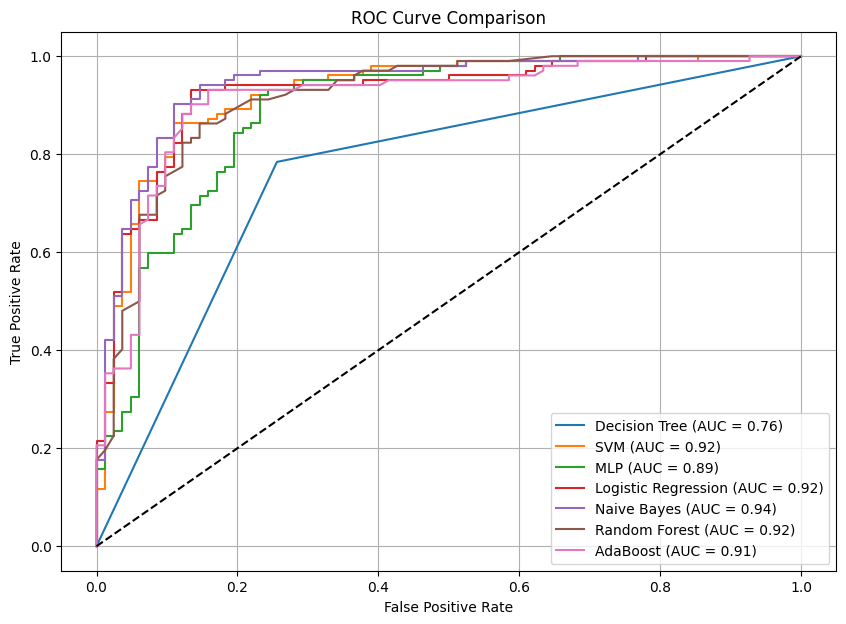

In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# ROC Curve Plot
plt.figure(figsize=(10, 7))
for name, model in models.items():
    y_proba = model.predict_proba(X_test)[:,1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.grid()
plt.show()

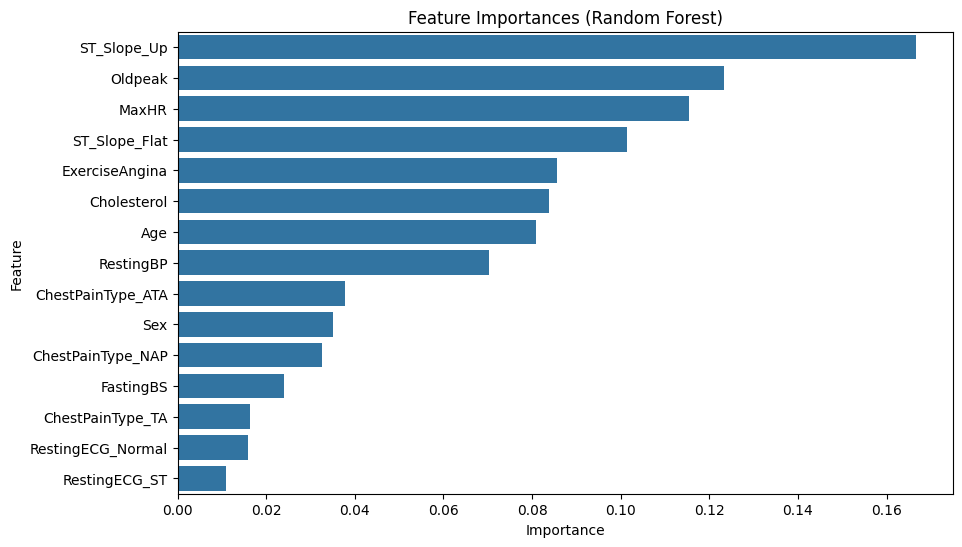

In [12]:
# Feature importance from Random Forest
importances = models['Random Forest'].feature_importances_
feat_names = X.columns
feat_imp_df = pd.DataFrame({'Feature': feat_names, 'Importance': importances})
feat_imp_df.sort_values(by='Importance', ascending=False, inplace=True)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feat_imp_df)
plt.title('Feature Importances (Random Forest)')
plt.show()